In [15]:
# Bagian 1: Memuat dan Menyiapkan Data Uji
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Path to your test data file
test_data_path = "new_test_data_BLT_DD.xlsx"

def load_and_prepare_test_data(test_data_path):
    test_df = pd.read_excel(test_data_path)

    # Encode categorical variables
    categorical_columns = ['Jenis Pekerjaan', 'Riwayat Penyakit Kronis', 'Tingkat Pendidikan', 'Status Kepemilikan Rumah',
                           'Kehilangan Mata Pencaharian', 'Anggota Keluarga Rentan', 'Tidak Menerima Bantuan Sosial',
                           'Rumah Tangga Lansia Tunggal', 'Perempuan Kepala Keluarga']
    
    for col in categorical_columns:
        le = LabelEncoder()
        test_df[col] = le.fit_transform(test_df[col])
    
    # Prepare features
    X_test = test_df.drop(columns=['Nama Keluarga', 'Alamat', 'Kabupaten', 'Kecamatan', 'Kategori'])
    
    return X_test, test_df

# Load and prepare test data
X_test, test_df = load_and_prepare_test_data(test_data_path)

# Tampilkan data uji yang sudah diproses
test_df.head()


,Nama Keluarga,Alamat,Kabupaten,Kecamatan,Pendapatan Per Bulan,Jenis Pekerjaan,Riwayat Penyakit Kronis,Tingkat Pendidikan,Status Kepemilikan Rumah,Kehilangan Mata Pencaharian,Anggota Keluarga Rentan,Tidak Menerima Bantuan Sosial,Rumah Tangga Lansia Tunggal,Perempuan Kepala Keluarga,Kategori
0,Ali,Jl. Mawar No.21,Aceh Utara,Matangkuli,550000,3,0,0,1,1,1,1,0,0,NaN
1,Budi,Jl. Cempaka No.22,Aceh Utara,Matangkuli,800000,2,1,1,0,0,0,0,1,1,NaN
2,Cici,Jl. Melati No.23,Aceh Utara,Baktiya,700000,1,0,1,0,0,0,1,0,1,NaN
3,Dewi,Jl. Dahlia No.24,Aceh Utara,Nibong,750000,4,1,0,1,1,1,0,1,0,NaN
4,Eko,Jl. Kenanga No.25,Aceh Utara,Samudera,650000,0,0,0,1,1,1,1,0,1,NaN


In [10]:
# Bagian 2: Memuat Model dan Scaler yang Sudah Disimpan
import joblib

# Path to the saved model and scaler
model_path = 'svm_model.pkl'
scaler_path = 'scaler.pkl'

# Load the saved model and scaler
model = joblib.load(model_path)
scaler = joblib.load(scaler_path)

print("Model dan scaler telah dimuat.")


Model dan scaler telah dimuat.


In [11]:
# Bagian 3: Standardisasi Data Uji
# Standardize test data
X_test_scaled = scaler.transform(X_test)

# Tampilkan beberapa baris data uji yang sudah distandardisasi
print("Data uji yang sudah distandardisasi:\n", X_test_scaled[:5])


Data uji yang sudah distandardisasi:
 [[-1.57200078  0.75093926 -0.8819171  -1.13389342  1.13389342  1.29099445
   0.77459667  1.13389342 -0.67419986 -1.13389342]
 [-0.40755576 -0.05006262  1.13389342  0.8819171  -0.8819171  -0.77459667
  -1.29099445 -0.8819171   1.4832397   0.8819171 ]
 [-0.87333376 -0.8510645  -0.8819171   0.8819171  -0.8819171  -0.77459667
  -1.29099445  1.13389342 -0.67419986  0.8819171 ]
 [-0.64044476  1.55194114  1.13389342 -1.13389342  1.13389342  1.29099445
   0.77459667 -0.8819171   1.4832397  -1.13389342]
 [-1.10622277 -1.65206638 -0.8819171  -1.13389342  1.13389342  1.29099445
   0.77459667  1.13389342 -0.67419986  0.8819171 ]]


In [17]:
# Bagian 4: Memprediksi Data Uji Menggunakan Model yang Sudah Dilatih
# Predict using the loaded model
predictions = model.predict(X_test_scaled)
decision_values = model.decision_function(X_test_scaled)

test_df['SVM Value'] = decision_values
test_df['Predicted Label'] = predictions
test_df['Predicted Label'] = test_df['Predicted Label'].apply(lambda x: 'Miskin Ekstrim' if x == 1 else 'Miskin')

# Output hasil prediksi
output_test_df = test_df[['Nama Keluarga', 'SVM Value', 'Predicted Label']]
display(output_test_df.head())


,Nama Keluarga,SVM Value,Predicted Label
0,Ali,0.888842,Miskin Ekstrim
1,Budi,2.599190,Miskin Ekstrim
2,Cici,1.429609,Miskin Ekstrim
3,Dewi,1.658363,Miskin Ekstrim
4,Eko,0.319861,Miskin Ekstrim


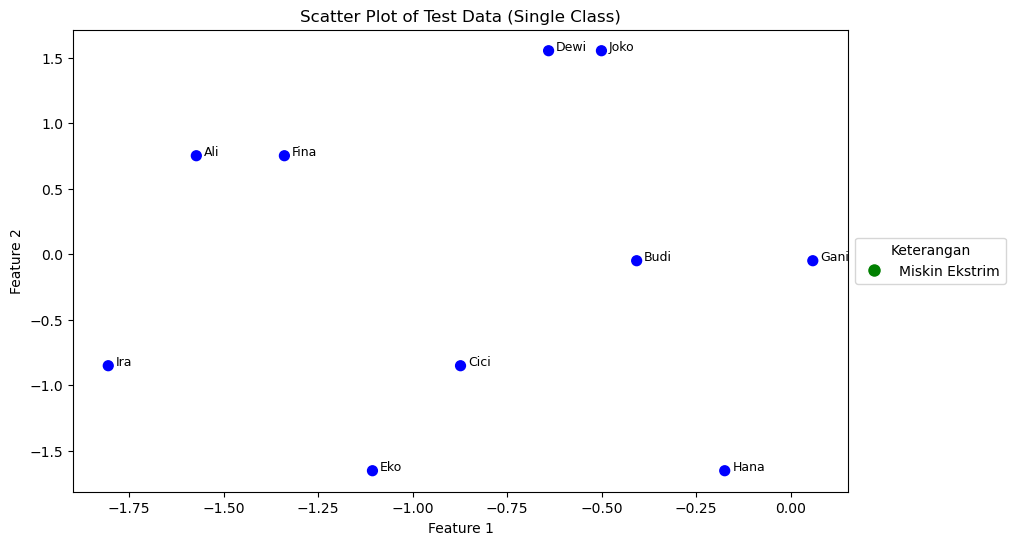

In [21]:
# Bagian 5: Visualisasi Hyperplane dengan Data Uji
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC

def visualize_hyperplane_test(X_test, model, df, predictions):
    plt.figure(figsize=(10, 6))

    # Reduce to 2D for visualization
    X_test_2d = X_test[:, :2]

    # Check the number of unique classes in predictions
    unique_classes = np.unique(predictions)
    if len(unique_classes) > 1:
        # Plot the points
        scatter = plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=predictions, cmap='winter', s=50)

        # Add annotations
        for i, (x, y) in enumerate(X_test_2d):
            plt.text(x + 0.02, y, df.iloc[i]["Nama Keluarga"], fontsize=9, ha='left')  # offset the text a bit

        ax = plt.gca()
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()

        xx = np.linspace(xlim[0], xlim[1], 30)
        yy = np.linspace(ylim[0], ylim[1], 30)
        YY, XX = np.meshgrid(yy, xx)
        xy = np.vstack([XX.ravel(), YY.ravel()]).T

        Z = model.decision_function(xy).reshape(XX.shape)
        ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
        ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100, linewidth=1, facecolors='none', edgecolors='k')

        plt.title('SVM Decision Boundary with Support Vectors (Test Data)')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')

        # Add legend for colors outside the plot
        colors = {0: 'blue', 1: 'green'}
        labels = {0: 'Miskin', 1: 'Miskin Ekstrim'}

        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors.values()]
        plt.legend(handles, labels.values(), title="Keterangan", loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        # Plot the points without decision boundary
        scatter = plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=predictions, cmap='winter', s=50)

        # Add annotations
        for i, (x, y) in enumerate(X_test_2d):
            plt.text(x + 0.02, y, df.iloc[i]["Nama Keluarga"], fontsize=9, ha='left')  # offset the text a bit

        plt.title('Scatter Plot of Test Data (Single Class)')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')

        # Add legend for colors outside the plot
        colors = {0: 'blue'} if unique_classes[0] == 0 else {1: 'green'}
        labels = {0: 'Miskin'} if unique_classes[0] == 0 else {1: 'Miskin Ekstrim'}

        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors.values()]
        plt.legend(handles, labels.values(), title="Keterangan", loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()

# Visualize the decision boundary with test data
visualize_hyperplane_test(X_test_scaled, model, test_df, predictions)
